# testing alignment python code

In [17]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from alignment import alignment_input, alignment_output

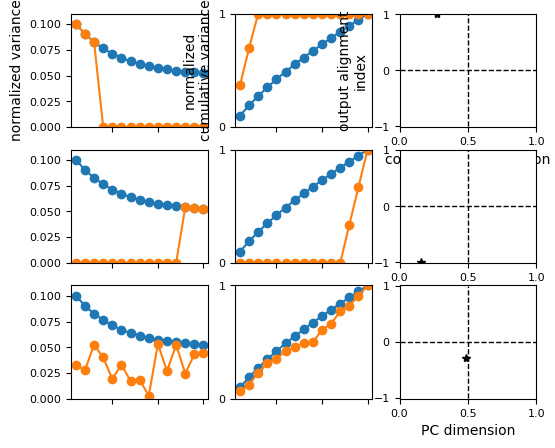

In [ ]:
# Parameters
T = 500
nx = 20
ny = 15
X = np.random.randn(T, nx)

rnk = 3
U = np.random.randn(nx, rnk)
V = np.random.randn(ny, rnk)

# Communication-only Y
Y_comm_only = X @ U @ V.T + np.random.randn(T, ny) * 0

# True W
W = U @ V.T

# Covariance basis for Y
basis, _ = np.linalg.qr(np.random.randn(ny, ny))  # orthogonal basis
tmp = np.linspace(0, 1, ny)
start_val, end_val = 2, 1
s_y = end_val + (start_val - end_val) * np.exp(-3 * tmp)
cov_Y = basis.T @ np.diag(s_y) @ basis

# Plot setup
fig, axes = plt.subplots(3, 3, figsize=(6, 5))
axes = axes.T.flatten()  # mimic MATLAB sub2ind indexing (column-major)

for ii in range(3):
    if ii == 0:  # align with output
        Y = Y_comm_only + np.random.randn(T, ny) * 10
        cov_XW = basis.T @ np.diag(np.r_[s_y[:rnk], np.zeros(ny - rnk)]) @ basis

    elif ii == 1:  # misalign with output
        tmp = np.random.randn(ny, ny - rnk)
        # Remove projection in direction of U*V'
        tmp = tmp - Y_comm_only.T @ (np.linalg.pinv(Y_comm_only.T) @ tmp)
        tmp = tmp / np.linalg.norm(tmp, axis=0, keepdims=True)
        Y = Y_comm_only + 1e3 * np.random.randn(T, ny - rnk) @ tmp.T
        cov_XW = basis.T @ np.diag(np.r_[np.zeros(ny - rnk), s_y[ny - rnk:]]) @ basis

    else:  # random
        Y = Y_comm_only + np.random.randn(T, ny) * 1e3
        cov_XW = basis.T @ np.diag(s_y * np.random.rand(ny)) @ basis

    # PCA on Y covariance
    _, spopvec, upop_T = np.linalg.svd(cov_Y)
    upop = upop_T.T
    spopcum = np.cumsum(spopvec)
    spopvec_nrm = spopvec / np.sum(spopvec)
    spopcum_nrm = np.cumsum(spopvec_nrm)

    # Project communication covariance
    cov_predicted = cov_XW
    scomvec = np.diag(upop.T @ cov_predicted @ upop)
    scomvec_nrm = scomvec / np.sum(scomvec)
    scomcum_nrm = np.cumsum(scomvec) / np.sum(scomvec)

    nd = len(spopvec)
    muscom = np.mean(scomcum_nrm)
    muspop = np.mean(spopcum_nrm)
    alignment_raw = muscom - muspop
    commfrac = np.sum(scomvec) / np.sum(spopvec)

    # Max alignment
    totcom = np.sum(scomvec)
    ind = np.argmax(spopcum > totcom + 1e-10)
    scommax = spopvec.copy()
    scommax[ind:] = 0
    scommax[ind] = totcom - np.sum(scommax[:ind])
    scommax_cum = np.cumsum(scommax) / np.sum(scommax)
    a_max = np.mean(scommax_cum) - muspop

    # Min alignment
    spopvec_rev = np.flipud(spopvec)
    spopcum_rev = np.cumsum(spopvec_rev)
    ind = np.argmax(spopcum_rev > totcom + 1e-10)
    scommin = spopvec_rev.copy()
    scommin[ind:] = 0
    scommin[ind] = totcom - np.sum(scommin[:ind])
    scommin = np.flipud(scommin)
    scommin_cum = np.cumsum(scommin) / np.sum(scommin)
    a_min = np.mean(scommin_cum) - muspop

    # Rescale alignment
    if alignment_raw > 0:
        a_out = alignment_raw / a_max
    else:
        a_out = alignment_raw / abs(a_min)

    


    # --- Plots ---
    ax = axes[ii]
    ax.plot(range(1, nd + 1), spopvec_nrm, "o-", label="Input variance")
    ax.plot(range(1, nd + 1), scomvec / np.sum(spopvec), "o-", label="Comm variance")
    ax.set_ylim([0, spopvec_nrm[0] * 1.1])
    ax.set_xlim([0.5, ny + 0.5])

    ax = axes[ii + 3]
    ax.plot(range(1, nd + 1), spopcum_nrm, "-o", label="Pop cumulative")
    ax.plot(range(1, nd + 1), scomcum_nrm, "o-", label="Comm cumulative")
    ax.set_ylim([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xlim([0.5, ny + 0.5])

    ax = axes[ii + 6]
    ax.plot(commfrac, a_out, "k*")
    ax.plot([0, 1], [0, 0], "k--", linewidth=1)
    ax.plot([0.5, 0.5], [-1, 1], "k--", linewidth=1)
    ax.set_ylim([-1.01, 1.01])
    ax.set_xlim([0, 1])
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([-1, 0, 1])
    ax.set_aspect("auto", adjustable="box")

# Labels
axes[0].set_ylabel("normalized variance")
axes[3].set_ylabel("normalized\ncumulative variance")
axes[6].set_ylabel("output alignment\nindex")
axes[7].set_xlabel("PC dimension")
axes[8].set_xlabel("PC dimension")
axes[6].set_xlabel("communication fraction")

# Formatting
for ax in axes[:6]:
    ax.set_xticklabels([])
for ax in axes:
    ax.tick_params(labelsize=8)
fig.set_size_inches(6, 5)
fig.savefig("fig6.png", dpi=300, bbox_inches="tight")
plt.show()


### Plot - input alignment

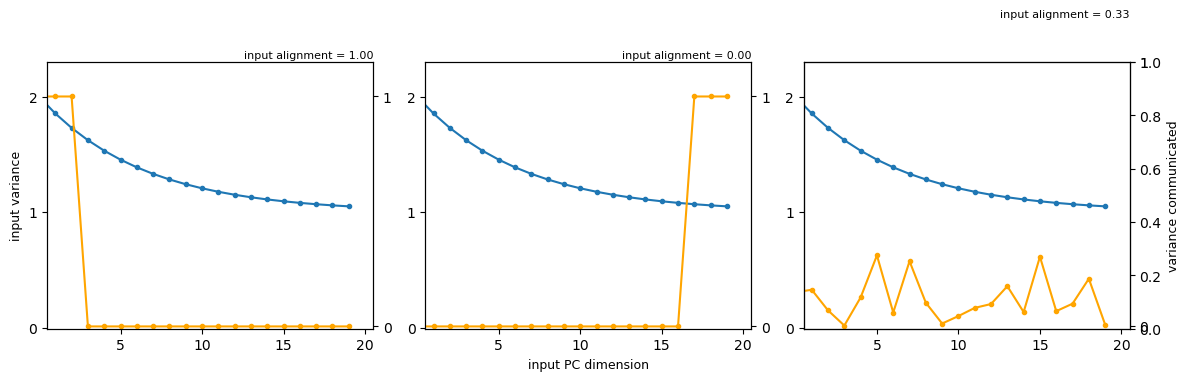

In [ ]:
# Parameters
T = 1000   # number of time points
nx = 20
ny = 15
r = 3      # rank of the communication subspace

# Generate input with fixed eigenvalues
basis, _ = np.linalg.qr(np.random.randn(nx, nx))  # random orthogonal basis

# create exponential decay eigenvalues
n_samples = 20
tmp = np.linspace(0, 1, n_samples)  # normalized time from 0 to 1
start_val = 2
end_val = 1
s = end_val + (start_val - end_val) * np.exp(-3 * tmp)  # adjust -3 for steepness

cov_X = basis @ np.diag(s) @ basis.T  # covariance of input

X = multivariate_normal.rvs(mean=np.zeros(nx), cov=cov_X, size=T)
# Input main axes (PCA on covariance)
Upca, Spcavec, _ = np.linalg.svd(cov_X)
# Communication weights
Ws = [
    Upca[:, :r],           # top r PCs
    Upca[:, -r:],          # bottom r PCs
    np.random.randn(nx, r) # random weights
]
from alignment import alignment_input
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ii in range(3):
    # Pick weight vector
    W = Ws[ii]
    W = W / np.linalg.norm(W,ord=2)  # normalize weight (magnitude does not affect alignment)

    # SVD of weights
    Uw, Swvec, Vw_T = np.linalg.svd(W)
    # Swvec = np.diag(np.diag(np.diag(np.atleast_2d(Swvec)))) if W.ndim > 1 else Swvec

    # Communicated variance
    var_comm = np.diag(Upca.T @ W @ W.T @ Upca)

    # Alignment index
    a_in, _, _ = alignment_input(X, W, r, cov_X)

    # -------- Make plot --------------
    ax = axes[ii]
    ax2 = ax.twinx()

    ax.plot(Spcavec, "o-", markersize=3, label="Input variance")
    ax2.plot(var_comm, "o-", markersize=3, color="orange", label="Communicated variance")

    ax.set_ylim([-0.01, max(Spcavec) * 1.15])
    ax2.set_ylim([-0.01, max(var_comm) * 1.15])

    ax.set_xlim([0.5, nx + 0.5])
    ax.set_yticks([0, 1, 2])
    ax2.set_yticks([0, 1])

    ax2.text(nx + 0.5, 1.2,
             f"input alignment = {a_in:.2f}",
             ha="right", va="top",
             fontsize=8, fontweight="normal")

# Axis labels
axes[0].set_ylabel("input variance", fontsize=9)       # MATLAB ax(1).YAxis(1).Label
axes[2].right_ax = axes[2].twinx()  # ensure right axis exists
axes[2].right_ax.set_ylabel("variance communicated", fontsize=9)

# X-axis label
axes[1].set_xlabel("input PC dimension", fontsize=9)

# Figure size in inches (MATLAB [0 0 7
plt.tight_layout()
plt.show()


## extensions

In [ ]:
# import from pacakges
from simu import simu_RRR
from fitting import *
import numpy as np

### Regularization

In [4]:
n_sim = 50
nx = 50
ny = 50
NSamples = np.round(50 * 2 ** np.arange(1, 4.5, 0.5)).astype(int)
Lambdas = np.array(list(range(11)) + [20, 100, 1000])

def err_fun(A, B):
    return np.mean((A - B) ** 2) / np.mean(B ** 2)

U = []
V = []
err = np.full((n_sim, len(Lambdas), len(NSamples)), np.nan)

# generate simulated data
for isim in range(n_sim):
    X, Y, U, V, ops = simu_RRR({
        'rnk': 2,
        'nx': nx,
        'ny': ny,
        'signse': 50,
        'T': max(NSamples),
        'U': U,
        'V': V
    })
    w_true = U @ V.T
    for jj, lam in enumerate(Lambdas):
        w_hat_list = [
            svd_RRR(X[:n_sample, :], Y[:n_sample, :], ops['rnk'], lam)[0]
            for n_sample in NSamples
        ]
        err[isim, jj, :] = [err_fun(w_hat, w_true) for w_hat in w_hat_list]

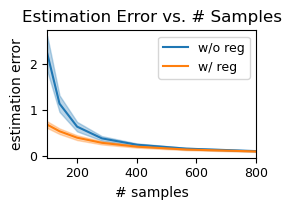

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Identify best lambda
tmp = np.mean(err, axis=0)  # shape: (len(Lambdas), len(NSamples))
I = np.argmin(tmp, axis=0)  # best lambda for each sample count

# Plotting
plt.close('all')
fig, ax = plt.subplots(figsize=(3, 2.2))  # size in inches
ax.set_title('Estimation Error vs. # Samples')

# Prepare data: err shape is (n_sim, len(Lambdas), len(NSamples))
# Select lambda index 0 (no regularization) and I[-1] (best at max sample)
selected_idxs = [0, I[-1]]
err_to_plot = err[:, selected_idxs, :]  # shape: (n_sim, 2, len(NSamples))
err_to_plot = np.transpose(err_to_plot, (0, 2, 1))  # shape: (n_sim, len(NSamples), 2)

# Plot mean ± std
labels = ['w/o reg', 'w/ reg']
colors = ['tab:blue', 'tab:orange']
for i in range(2):
    mean_err = np.mean(err_to_plot[:, :, i], axis=0)
    std_err = np.std(err_to_plot[:, :, i], axis=0)
    ax.plot(NSamples, mean_err, label=labels[i], color=colors[i])
    ax.fill_between(NSamples, mean_err - std_err, mean_err + std_err, color=colors[i], alpha=0.3)

# Labels and legend
ax.set_xlabel('# samples')
ax.set_ylabel('estimation error')
ax.legend(fontsize=9)
ax.set_xlim(min(NSamples), max(NSamples))
ax.tick_params(labelsize=9)

# Save figure
plt.tight_layout()
plt.savefig('fig2a.png', dpi=300)
plt.show()


### Non-isotropic noise

In [4]:
# simulation parameters
n_sim = 100
nx = 50
ny = 50
Lambdas = np.array(list(range(11)) + [20, 100, 1000])
M_sigma = np.linspace(1,500,6) # maximum variance of neurons

def err_fun(A, B):
    return np.mean((A - B) ** 2) / np.mean(B ** 2)


err = np.full((n_sim, len(M_sigma), 2), np.nan)

In [5]:
# generate simulated data
for ii in range(len(M_sigma)):
    
    # generate groudn truth covariance
    # Sigma = np.diag(np.logspace(0, np.log10(M_sigma[ii]), ny)) # variance on a log scale
    # Sigma = np.diag(np.linspace(1, M_sigma[ii], ny)) # variance on a linear scale
    Sigma = np.diag(np.concatenate([np.ones(ny - 1), [M_sigma[ii]]])) # variance all ones except the last
    
    for isim in range(n_sim):
        X, Y, U, V, ops = simu_RRR({
            'rnk': 2,
            'nx': nx,
            'ny': ny,
            'signse': 50,
            'T': 100,
            'Sigma':Sigma})
        w_true = U @ V.T
        
        w_hat_list = [svd_RRR(X,Y,ops['rnk'])[0], 
                      svd_RRR_noniso(X,Y,ops['rnk'],Sigma)[0]]
        err[isim, ii, :] = [err_fun(w_hat, w_true) for w_hat in w_hat_list]

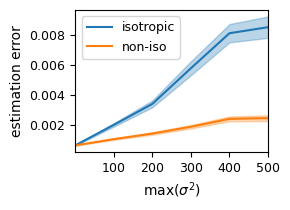

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Example structure
# err.shape == (n_sim, len(M_sigma), 2)
# M_sigma = [10, 100, 1000]  # or any list of values

plt.close('all')
fig, ax = plt.subplots(figsize=(3, 2.2))  # inches, as in MATLAB [3 2.2]*72 dpi

colors = plt.get_cmap('tab10').colors  # similar to MATLAB 'lines' colormap

labels = ['isotropic', 'non-iso']

for ii in range(2):
    mean_err = np.mean(err[:, :, ii], axis=0)
    std_err = np.std(err[:, :, ii], axis=0) / np.sqrt(err.shape[0])
    ax.plot(M_sigma, mean_err, label=labels[ii], color=colors[ii])
    ax.fill_between(M_sigma, mean_err - std_err, mean_err + std_err, color=colors[ii], alpha=0.3)

# Axis labels
ax.set_xlabel(r'max($\sigma^2$)', fontsize=10)
ax.set_ylabel('estimation error', fontsize=10)

# Legend
ax.legend(fontsize=9)

# Axes formatting
ax.set_xlim(min(M_sigma), max(M_sigma))
ax.tick_params(labelsize=9)

# Layout and save
plt.tight_layout()
plt.savefig('fig2b.png', dpi=300)
plt.show()
